In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import emoji
import warnings
warnings.filterwarnings('ignore')

In [56]:
#Opening chat file using open method and encoding as utf8 to read all characters
f=open('_chat.txt',mode='r',encoding='utf8')
whatsapp=f.read()
f.close()

In [57]:
#Extracting all the timestamp(date+time) using regex
timestamp=re.findall('\d+\/\d+\/\d+, \d+\:\d+\:\d+ \w+',whatsapp)
#Finding index of all the timestamp which will be used later to extract message content
indexes=[whatsapp.find(i) for i  in timestamp]
df=pd.DataFrame({'timestamp':timestamp,'indexes':indexes})

In [58]:
#Finding author of the group
author=re.findall('\+\d+',str(whatsapp[df.indexes[1]:df.indexes[2]].encode('ascii','ignore')))
print(f'Author of the group is {author}')

Author of the group is ['+916302217120']


In [59]:
# Extracting complete message content by slicing on timestamp index
#so that mulit line messages are also captured in single row 
df=df[3:]
cont=[]
for i in df.index:
    try:
        cont.append(whatsapp[df.indexes[i]:df.indexes[i+1]])
    except:
        cont.append(whatsapp[df.indexes[i]:])

In [60]:
df['message']=cont

In [61]:
df.head()

,timestamp,indexes,message
3,"13/12/19, 10:26:18 AM",245,"13/12/19, 10:26:18 AM] ‪+91 98737 78438‬: Hell..."
4,"13/12/19, 10:26:56 AM",352,"13/12/19, 10:26:56 AM] ‪+91 89774 42577‬: Can ..."
5,"13/12/19, 10:31:47 AM",421,"13/12/19, 10:31:47 AM] ‪+91 98737 78438‬: ‎ima..."
6,"13/12/19, 10:32:03 AM",479,"13/12/19, 10:32:03 AM] ‪+91 98737 78438‬: Line..."
7,"13/12/19, 10:42:06 AM",534,"13/12/19, 10:42:06 AM] ‪+91 89774 42577‬: It w..."


In [62]:
#Extracting Sender from the message part
df['Sender']=df.message.str.extract('(\]\+*.*?\:)')
df.Sender=df.Sender.astype(str)
df.Sender=df.Sender.apply(lambda x:x[1:-1])

In [63]:
#Extracting message content separately without sender and timestamp
df.message=df.message.str.extract('(: .*)',re.S)
df.message=df.message.astype(str)
df.message=df.message.apply(lambda x:x[1:-2])
df.message=df.message.str.replace('\n','')

In [65]:
#Extracting time and date separately from timestamp column
df['Date']=df.timestamp.str.extract('(\d+\/\d+\/\d+)')
df['Time']=df.timestamp.str.extract('(\d+\:\d+\:\d+ \w+)')

In [66]:
#Removing redundant columns
df=df[['Date','Time','Sender','message']]
df=df.reset_index(drop=True)

In [67]:
df.head()

,Date,Time,Sender,message
0,13/12/19,10:26:18 AM,‪+91 98737 78438‬,"Hello everyone,I have one doubt regarding (?:..."
1,13/12/19,10:26:56 AM,‪+91 89774 42577‬,Can you send full line ?
2,13/12/19,10:31:47 AM,‪+91 98737 78438‬,‎image omitted
3,13/12/19,10:32:03 AM,‪+91 98737 78438‬,Line no. 39
4,13/12/19,10:42:06 AM,‪+91 89774 42577‬,It will find the word but you cannot retrieve...


### Number of messages sent by each member of the group

In [68]:
df.Sender.nunique()

49

In [69]:
d=dict()
for i in df.Sender.str.encode('ascii','ignore').str.decode('utf-8'):
    d[i]=d.get(i,0)+1
Sender=list(d.keys())
No_of_messages=list(d.values())

    

In [70]:
df_message=pd.DataFrame({'Sender':Sender,'No_of_Messages':No_of_messages},index=np.arange(0,len(d)))

In [71]:
df_message.head()

,Sender,No_of_Messages
0,+919873778438,11
1,+918977442577,22
2,+919131014850,5
3,+918296770134,17
4,+919662807005,64


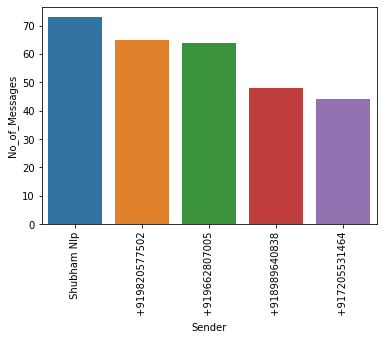

In [72]:
# Top 5 people who message the most
a=df_message.sort_values(by='No_of_Messages',ascending=False).head()
sns.barplot(x=a.Sender,y=a.No_of_Messages)
plt.xticks(rotation=90)
plt.show()

### No of messages in each hour of day

In [73]:
df.Date.nunique()

28

In [74]:
#separating PM and AM Time
AM=[]
PM=[]
for i in df.Time:
    if'AM' in i:
        AM.append(i.split(' AM')[0].split(':')[0])
    else:
        PM.append(i.split(' PM')[0].split(':')[0])

In [75]:
#Converting into 24 hour format
for i in range(0,len(PM)):
    if PM[i]!='12':
        PM[i]=int(PM[i])+12
    else:
        PM[i]=int(PM[i])
AM=[int(i) for i in AM]

In [76]:
df['Hour']=AM+PM
df_hour=dict()
for i in df.Hour:
    df_hour[i]=df_hour.get(i,0)+1

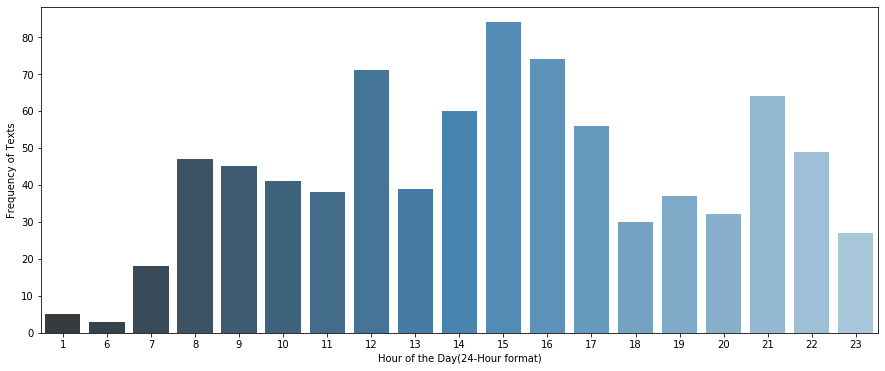

In [77]:
plt.figure(figsize=(15,6))
sns.barplot(x=list(df_hour.keys()),y=list(df_hour.values()),palette=("Blues_d"))
plt.xlabel('Hour of the Day(24-Hour format)')
plt.ylabel('Frequency of Texts')
plt.show()

In [78]:
#We can infer here that most message exchanged are around 3 PM

### Most active day of week

In [79]:
import datetime
def findDay(date): 
    day, month, year = (int(i) for i in str(date).split('/'))     
    time1 = datetime.date(year, month, day) 
    return time1.strftime("%a") 

In [80]:
df['Day']=df.Date.apply(lambda x:findDay(x))

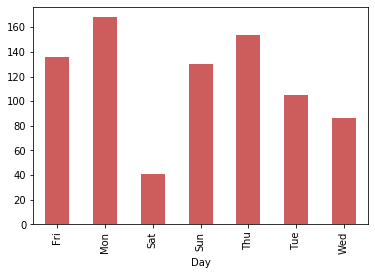

In [81]:
df.groupby(by='Day')['Day'].count().plot.bar(color='indianred')
plt.show()

In [82]:
#Here we can clearly see that most messages are exchanged on Monday.

### Count of emojis

In [83]:
#Finding frequency of all emojis

emojis=[j for i in df.message  for j in str(i) if j in emoji.UNICODE_EMOJI]
emodict=dict()
for i in emojis:
    emodict[i]=emodict.get(i,0)+1
    

In [94]:
emo=pd.DataFrame({'emoji':list(emodict.keys()),'Freq':list(emodict.values())})
emo=emo.sort_values(by='Freq',ascending=False)

In [100]:
emo

,emoji,Freq
0,👍,36
13,🏻,14
4,😊,8
1,😂,7
8,😀,5
19,😁,4
7,😅,4
12,✌,3
6,🤟,3
16,🏼,3


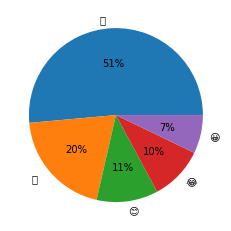

In [99]:
from matplotlib.font_manager import FontProperties

prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')
plt.rcParams['font.family'] = prop.get_family()

plt.pie(emo.Freq.head(),labels=emo.emoji.head(),autopct='%.0f%%')
plt.show()

In [85]:
#Clearly, Thumbs up 👍 is the most frequently used emoji and 
#we can say students are pretty satisfied from the course and hence the thumbs up

In [87]:
def emo_find(x):
    for i in str(x):
        if i in emoji.UNICODE_EMOJI:
            return i
        else:
            return "No emoji used"

In [88]:
df['emo_used']=df.message.apply(lambda x:emo_find(x))

In [54]:
df.Sender[1]

' \u202a+91\xa089774\xa042577\u202c'

In [101]:
df.drop(columns='emo_used',inplace=True)

### Avg Message length, word length of each person

In [103]:
df['Message_length']=df.message.apply(lambda x:len(x))

In [128]:
a=df.groupby(by='Sender')['Message_length'].mean().sort_values(ascending=False).reset_index()

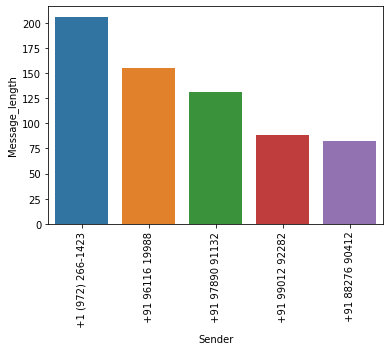

In [130]:
sns.barplot(x=a.Sender.head(),y=a.Message_length.head())
plt.xticks(rotation=90)
plt.show()

In [131]:
#Here we can see the avg message length of member(+1 (972) 266-1423) is thr highest 

In [132]:
import nltk

In [134]:
df['Word_count']=df.message.apply(lambda x:len(nltk.word_tokenize(x)) )

In [137]:
b=df.groupby(by='Sender')['Word_count'].mean().sort_values(ascending=False).reset_index()

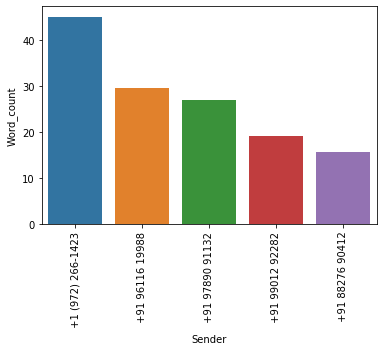

In [138]:
sns.barplot(x=b.Sender.head(),y=b.Word_count.head())
plt.xticks(rotation=90)
plt.show()